In [55]:
import requests
import os
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from time import sleep
# Objective website
user_agent = 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.47 Safari/537.36'
headers = {'User-Agent': user_agent}
URL = 'https://www.cervezasonline.com/'
session = requests.Session()

In [56]:
#First we want to check the robots.txt file of our objective website
#A function get_robot_txt is constructed to check any url
def get_robot_txt(url):
    if url.endswith('/'):
        path = url
    else:
        path = url + '/'
    req = requests.get(path + "robots.txt",data =None)
    return req.text
# Read robots.txt file
# No product pages within any Disallow
print(get_robot_txt(URL))

# robots.txt automaticaly generated by PrestaShop e-commerce open-source solution
# http://www.prestashop.com - http://www.prestashop.com/forums
# This file is to prevent the crawling and indexing of certain parts
# of your site by web crawlers and spiders run by sites like Yahoo!
# and Google. By telling these "robots" where not to go on your site,
# you save bandwidth and server resources.
# For more information about the robots.txt standard, see:
# http://www.robotstxt.org/robotstxt.html
User-agent: *
# Allow Directives
Allow: */modules/*.css
Allow: */modules/*.js
# Private pages
Disallow: /*?orderby=
Disallow: /*?orderway=
Disallow: /*?tag=
Disallow: /*?id_currency=
Disallow: /*?search_query=
Disallow: /*?back=
Disallow: /*?n=
Disallow: /*&orderby=
Disallow: /*&orderway=
Disallow: /*&tag=
Disallow: /*&id_currency=
Disallow: /*&search_query=
Disallow: /*&back=
Disallow: /*&n=
Disallow: /*controller=addresses
Disallow: /*controller=address
Disallow: /*controller=authentication
Disall

In [57]:
# Class Category. All of the identified categories have one of these
class Category:
  def __init__(self, category_url=None):
    if category_url[-1] == '#': self.url = category_url[:-1]
    else: self.url = category_url    

  # Identify if there is a 'Show All' option
  def get_all_products_web_page(self):
    soup = BeautifulSoup(session.get(self.url, headers=headers).content, 'html.parser')
    try: 
      # Identify number of All products in "Mostrar Todos" button
      value = soup.find(id='pagination').find(id='nb_item')['value']
      # Create new URL with the new parametres of number of producst as n
      self.url = self.url+'?n='+value
    except: pass

  # Identify all the products in a category page
  def get_all_product_links(self):
    # Get page with all products from category
    self.get_all_products_web_page()
    soup = BeautifulSoup(session.get(self.url, headers=headers).content, 'html.parser')
    # Get all product links one by one from html code
    product_links = [product['href'] for product in soup.findAll('a', class_='product_img_link')]
    print("Category URL: ", self.url)
    print("Number of products in category: ", len(product_links))
    return(product_links)

In [58]:
# This method returns all producst identified in the website
def get_all_products(url):
  # Identify all categories on the top block div
  soup = BeautifulSoup(session.get(url, headers=headers).content, 'html.parser')
  # Get all identified categories
  # Detele all categories that are longer than one subdomain
  categories = ['/'.join((url + category['href'][1:]).split('/')[0:4]) for category in soup.find(id='block_top_menu').find_all('a') if category['href']!='#' and category['href'][0]=='/']
  # Create categories with only unqiue urls
  categories = [Category(category) for category in list(set(categories))]
  # Get all the links to products per cateogry
  products = []
  [products.extend(category.get_all_product_links()) for category in categories]
  # Get only unique URLs
  products = list(set(products))
  print("Total number of products: ", len(products))
  return(products)

# Call function get_all_products() to get all products from 'https://www.cervezasonline.com/' website
# Parse all of the products in the website


In [96]:

def substring_after(s, delim):
    return s.partition(delim)[2]

# This function returns a pandas dataframe containing 9 fiedls: Beer category, beer name, beer size, beer type, beer color,
# beer graduation, beer price and beer unitary price for a list of URLs from 'https://www.cervezasonline.com/' website.

def process_cervezasonline_data(URL):
    df = pd.DataFrame()
    for url in URL:
        response = requests.get(url)
        soup = BeautifulSoup(response.content, "html.parser")

        results = soup.find(id='product')

        product_name = results.find('div', class_='product_desc')
        product_desc = results.find('div', class_='product_desc')
        
        try:
            product_detail = results.find_all('div', class_='rte')[1].text
        except IndexError:
            product_detail = 'NA'
        
        try:
            product_price = soup.find('p', class_='our_price_display').text
        except AttributeError:
            product_price = 'NA'
        
        try:
            unit_price = soup.find('p', class_='unit-price').text
        except AttributeError:
            unit_price = 'NA'
        
        l = []
        product_desc = product_desc.text.replace("Tipo :","Tipo:").replace("Color :","Color:").replace("Origen :","Origen:").replace("Graduación :","Graduación:")
        l.append([
        # Get beer category DF field    
        substring_after(url,"https://www.cervezasonline.com/").split('/', 1)[0].strip().upper(), 
        
        # Get beer name DF field
        product_name.text.strip().split('Origen', 1)[0].replace(product_name.text.strip().
                                                                split('Origen', 1)[0][product_name.text.strip().
                                                                split('Origen', 1)[0].strip().rindex(' ')+1:],"").strip(),
        
        # Get beer size DF field
        product_name.text.strip().split('Origen', 1)[0][product_name.text.strip().split('Origen', 1)[0].strip().
                                                                  rindex(' ')+1:].upper().replace(",",".").strip(),
        
        # Get beer origin DF field
        substring_after(product_desc.strip(),"Origen:").
        replace(substring_after(product_desc.strip(),"Tipo:"),"").replace("Tipo:","").strip(),
        
        # Get beer type DF field
        substring_after(product_desc.strip(),"Tipo:").
        replace(substring_after(product_desc.strip(),"Color:"),"").replace("Color:","").strip(),
        
        # Get beer color DF field          
        substring_after(product_desc.strip(),"Color:").
        replace(substring_after(product_desc.strip(),"Graduación:"),"").replace("Graduación:","").strip(),
        
        # Get beer graduation DF field 
        substring_after(product_desc.strip(),"Graduación:"),
        
        # Get beer price DF field 
        product_price.replace(",",".").replace(" ","").split('€', 1)[0].strip(),

        # Get beer unitary price DF field 
        unit_price.replace(",",".").replace(" ","").split('€', 1)[0].strip(),
            
        # Get beer detailed description
        product_detail.strip()        
             
             ])

        # We append to a pandas dataframe new data for each URL. Also we add DF colum names and reset the index
        df = df.append(pd.DataFrame(l,columns = ['Categoria','Nombre de la Cerveza', 'Tamaño','Origen','Tipo','Color',
                                             'Graduación','Precio en €','Precio por Litro en €','Descripcion'])).reset_index(drop=True)

    return(df)
    


In [97]:
df = process_cervezasonline_data(get_all_products('https://www.cervezasonline.com/'))

Category URL:  https://www.cervezasonline.com/299-cristaleria?n=210
Number of products in category:  210
Category URL:  https://www.cervezasonline.com/341-botellon-metal
Number of products in category:  11
Category URL:  https://www.cervezasonline.com/309-botellones?n=160
Number of products in category:  160
Category URL:  https://www.cervezasonline.com/304-latas
Number of products in category:  19
Category URL:  https://www.cervezasonline.com/312-estuche?n=57
Number of products in category:  57
Category URL:  https://www.cervezasonline.com/302-botella-cerveza?n=523
Number of products in category:  523
Category URL:  https://www.cervezasonline.com/379-selecciones
Number of products in category:  1
Category URL:  https://www.cervezasonline.com/340-estuche-madera
Number of products in category:  7
Category URL:  https://www.cervezasonline.com/378-keykeg
Number of products in category:  2
Category URL:  https://www.cervezasonline.com/380-seleccion-de-verano
Number of products in category:

In [75]:
df.to_csv(r'C:\Users\guillermo.arguello\Documents\Master Data Science UOC\Tipología y ciclo de vida de los datos\Pec1 2020\prac_1_beers_web_scrapping_initial_df.csv',
          encoding = 'ANSI',index=False)

En este punto hemos conseguido un dataframe de pandas con todos los productos de la web y los campos que necesitamos. Vamos a explorar el dataframe y eliminar los registros que no nos son útiles para el análisis. 

In [98]:
df.head(10)

,Categoria,Nombre de la Cerveza,Tamaño,Origen,Tipo,Color,Graduación,Precio en €,Precio por Litro en €,Descripcion
0,BOTELLA-CERVEZA,Seefbier,33CL,Bélgica,Ale,Rubio turbio,6.5º,1.90,6.97,"Cerveza belga artesanal de estilo Pale Ale, co..."
1,BOTELLA-CERVEZA,Houblon Chouffe,33CL,Bélgica,Indian Pale Ale,Rubia turbia,9º,2.60,9.53,"""Houblon"" significa lúpulo en francés, con lo ..."
2,CRISTALERIA,Vaso Judas,33CL,,,,,4.15,NA,NA
3,BOTELLA-CERVEZA,Lluna Blat,33CL,España,Trigo Artesanal,Rubio pálido,4.3º,2.45,8.98,"Cerveza de alta fermentación, elaborada con ag..."
4,BOTELLA-CERVEZA,Anchor Steam Beer,35.5CL,EE.UU.,Ale,Ámbar,4.8º,2.95,10.06,Elaborada artesanalmente en San Francisco (U.S...
5,BOTELLONES,Hommelbier,75CL,Bélgica,Especial,Rubia ambarina,7.5º,4.60,7.42,El aroma a malta se mezcla de forma exquisita ...
6,CRISTALERIA,Vaso,BELLIBOCK,,,,,2.50,NA,NA
7,BOTELLA-CERVEZA,Het Kapittel Pater,33CL,Bélgica,Abadía,Tostado oscuro,6º,1.65,6.05,Espuma delicada y frágil. El aroma ligeramente...
8,CRISTALERIA,Vaso Gulden Draak Copa Huevo,DRAGON,,,,,4.20,NA,NA
9,BOTELLA-CERVEZA,Rodenbach Gran Cru,33CL,Bélgica,Ale,Marrón caoba,6º,2.40,8.80,Una mezcla de 1/3 de cerveza joven y 2/3 de ce...


In [99]:
data_beers_web_sacraping = df
data_beers_web_sacraping.groupby('Categoria').count()

,Nombre de la Cerveza,Tamaño,Origen,Tipo,Color,Graduación,Precio en €,Precio por Litro en €,Descripcion
Categoria,,,,,,,,,
BOTELLA,1,1,1,1,1,1,1,1,1
BOTELLA-CERVEZA,522,522,522,522,522,522,522,522,522
BOTELLON-METAL,11,11,11,11,11,11,11,11,11
BOTELLONES,160,160,160,160,160,160,160,160,160
CRISTALERIA,210,210,210,210,210,210,210,210,210
ESTUCHE,57,57,57,57,57,57,57,57,57
ESTUCHE-MADERA,7,7,7,7,7,7,7,7,7
INICIO,2,2,2,2,2,2,2,2,2
KEY-KEG,1,1,1,1,1,1,1,1,1


In [100]:
#Eliminamos el registro con categoria 'INICIO' porque no tiene valor y sustituimos los campos NA por NaN
data_beers_web_sacraping.drop( data[ data['Categoria'] == 'INICIO' ].index , inplace=True)
data_beers_web_sacraping = data_beers_web_sacraping.replace("NA", np.NaN)


In [101]:
#Vamos a ver que categorias no tienen precios unitarios

data_beers_web_sacraping[data_beers_web_sacraping['Precio por Litro en €'].isna()].groupby('Categoria').count()


,Nombre de la Cerveza,Tamaño,Origen,Tipo,Color,Graduación,Precio en €,Precio por Litro en €,Descripcion
Categoria,,,,,,,,,
BOTELLA-CERVEZA,11,11,11,11,11,11,9,0,11
BOTELLONES,1,1,1,1,1,1,1,0,1
CRISTALERIA,210,210,210,210,210,210,210,0,0
ESTUCHE,57,57,57,57,57,57,57,0,2
ESTUCHE-MADERA,7,7,7,7,7,7,7,0,0
INICIO,1,1,1,1,1,1,1,0,0
LATAS,2,2,2,2,2,2,2,0,2


Vamos a eliminar todos los registros del dataframe con campos NaN ya que no nos interesan para el analisis posterior. Como vemos son la mayoria cristaleria y estuches de regalo.

In [109]:
data_beers_web_sacraping = data_beers_web_sacraping.dropna()
data_beers_web_sacraping.info()
data_beers_web_sacraping.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 685 entries, 0 to 988
Data columns (total 11 columns):
Categoria                685 non-null object
Nombre de la Cerveza     685 non-null object
Tamaño                   685 non-null object
Origen                   685 non-null object
Tipo                     685 non-null object
Color                    685 non-null object
Graduación               685 non-null object
Precio en €              685 non-null object
Precio por Litro en €    685 non-null object
Descripcion              685 non-null object
Color Simplificado       685 non-null object
dtypes: object(11)
memory usage: 64.2+ KB


,Categoria,Nombre de la Cerveza,Tamaño,Origen,Tipo,Color,Graduación,Precio en €,Precio por Litro en €,Descripcion,Color Simplificado
count,685,685,685,685,685,685,685,685,685,685,685
unique,7,599,26,28,64,198,126,183,277,586,33
top,BOTELLA-CERVEZA,Namur Blanche,33CL,Bélgica,Ale,Rubia,8º,2.00,8.06,"De aspecto rubia, turbia y de color lechoso (t...",Rubia
freq,507,4,390,447,185,69,39,28,21,4,192


In [115]:
data_beers_web_sacraping["Precio en €"] = pd.to_numeric(data_beers_web_sacraping["Precio en €"])
data_beers_web_sacraping["Precio por Litro en €"] = pd.to_numeric(data_beers_web_sacraping["Precio por Litro en €"])
data_beers_web_sacraping.describe()

,Precio en €,Precio por Litro en €
count,685.000000,685.000000
mean,4.509416,9.242029
std,8.873834,5.271836
min,0.500000,1.630000
25%,2.000000,7.110000
50%,2.350000,8.140000
75%,4.300000,9.540000
max,131.400000,51.620000


In [116]:
#Vamos a crear una nueva columna para el color sólo con la primera palabra y en femenino, para generar menos categorias.
data_beers_web_sacraping['Color Simplificado'] = data_beers_web_sacraping['Color'].str.split().str.get(0)
data_beers_web_sacraping.loc[data_beers_web_sacraping['Color Simplificado'].str[-1] == "o", 'Color Simplificado'] = data_beers_web_sacraping['Color Simplificado'].str[:-1] + 'a'
data_beers_web_sacraping.groupby('Color Simplificado').count().reset_index().sort_values("Categoria",ascending=False)


,Color Simplificado,Categoria,Nombre de la Cerveza,Tamaño,Origen,Tipo,Color,Graduación,Precio en €,Precio por Litro en €,Descripcion
28,Rubia,192,192,192,192,192,192,192,192,192,192
32,Ámbar,97,97,97,97,97,97,97,97,97,97
10,Dorada,96,96,96,96,96,96,96,96,96,96
22,Oscura,59,59,59,59,59,59,59,59,59,59
14,Marrón,54,54,54,54,54,54,54,54,54,54
25,Roja,45,45,45,45,45,45,45,45,45,45
0,Amarilla,31,31,31,31,31,31,31,31,31,31
9,Cobriza,13,13,13,13,13,13,13,13,13,13
19,Negra,11,11,11,11,11,11,11,11,11,11
26,Rojiza,9,9,9,9,9,9,9,9,9,9


In [117]:
data_beers_web_sacraping.head()

,Categoria,Nombre de la Cerveza,Tamaño,Origen,Tipo,Color,Graduación,Precio en €,Precio por Litro en €,Descripcion,Color Simplificado
0,BOTELLA-CERVEZA,Seefbier,33CL,Bélgica,Ale,Rubio turbio,6.5º,1.90,6.97,"Cerveza belga artesanal de estilo Pale Ale, co...",Rubia
1,BOTELLA-CERVEZA,Houblon Chouffe,33CL,Bélgica,Indian Pale Ale,Rubia turbia,9º,2.60,9.53,"""Houblon"" significa lúpulo en francés, con lo ...",Rubia
3,BOTELLA-CERVEZA,Lluna Blat,33CL,España,Trigo Artesanal,Rubio pálido,4.3º,2.45,8.98,"Cerveza de alta fermentación, elaborada con ag...",Rubia
4,BOTELLA-CERVEZA,Anchor Steam Beer,35.5CL,EE.UU.,Ale,Ámbar,4.8º,2.95,10.06,Elaborada artesanalmente en San Francisco (U.S...,Ámbar
5,BOTELLONES,Hommelbier,75CL,Bélgica,Especial,Rubia ambarina,7.5º,4.60,7.42,El aroma a malta se mezcla de forma exquisita ...,Rubia


In [118]:
import plotly.graph_objects as go
from collections import Counter

fig = go.Figure()
fig.add_trace(go.Histogram(histfunc="count", y=data_beers_web_sacraping['Origen'], x=data_beers_web_sacraping['Origen'], name="COUNT")).update_xaxes(categoryorder="total descending")
fig.update_layout(
    title="Número de cervezas por origen"
)
fig.show()
fig.write_html(r"C:\Users\guillermo.arguello\Documents\Master Data Science UOC\Tipología y ciclo de vida de los datos\Pec1 2020\Número de cervezas por origen.html")


fig = go.Figure()
fig.add_trace(go.Histogram(histfunc="count", y=data_beers_web_sacraping['Tipo'], x=data_beers_web_sacraping['Tipo'], name="COUNT")).update_xaxes(categoryorder="total descending")
fig.update_layout(
    title="Número de cervezas por tipo"
)
fig.show()
fig.write_html(r"C:\Users\guillermo.arguello\Documents\Master Data Science UOC\Tipología y ciclo de vida de los datos\Pec1 2020\Número de cervezas por tipo.html")


fig = go.Figure()
fig.add_trace(go.Histogram(histfunc="count", y=data_beers_web_sacraping['Precio por Litro en €'], x=data_beers_web_sacraping['Precio por Litro en €'], name="COUNT")).update_xaxes(categoryorder="total descending")
fig.update_layout(
    title="Precio por Litro en €"
)
fig.show()
fig.write_html(r"C:\Users\guillermo.arguello\Documents\Master Data Science UOC\Tipología y ciclo de vida de los datos\Pec1 2020\Precio por Litro.html")



fig = go.Figure()
fig.add_trace(go.Histogram(histfunc="count", y=data_beers_web_sacraping['Graduación'].str.strip().str.replace(",",".").str.replace("º","").str.strip(),
                           x=data_beers_web_sacraping['Graduación'].str.strip().str.replace(",",".").str.replace("º","").str.strip()
                           , name="COUNT")).update_xaxes(categoryorder="total descending")
fig.update_layout(
    title="Graduación"
)
fig.show()
fig.write_html(r"C:\Users\guillermo.arguello\Documents\Master Data Science UOC\Tipología y ciclo de vida de los datos\Pec1 2020\Graduación.html")


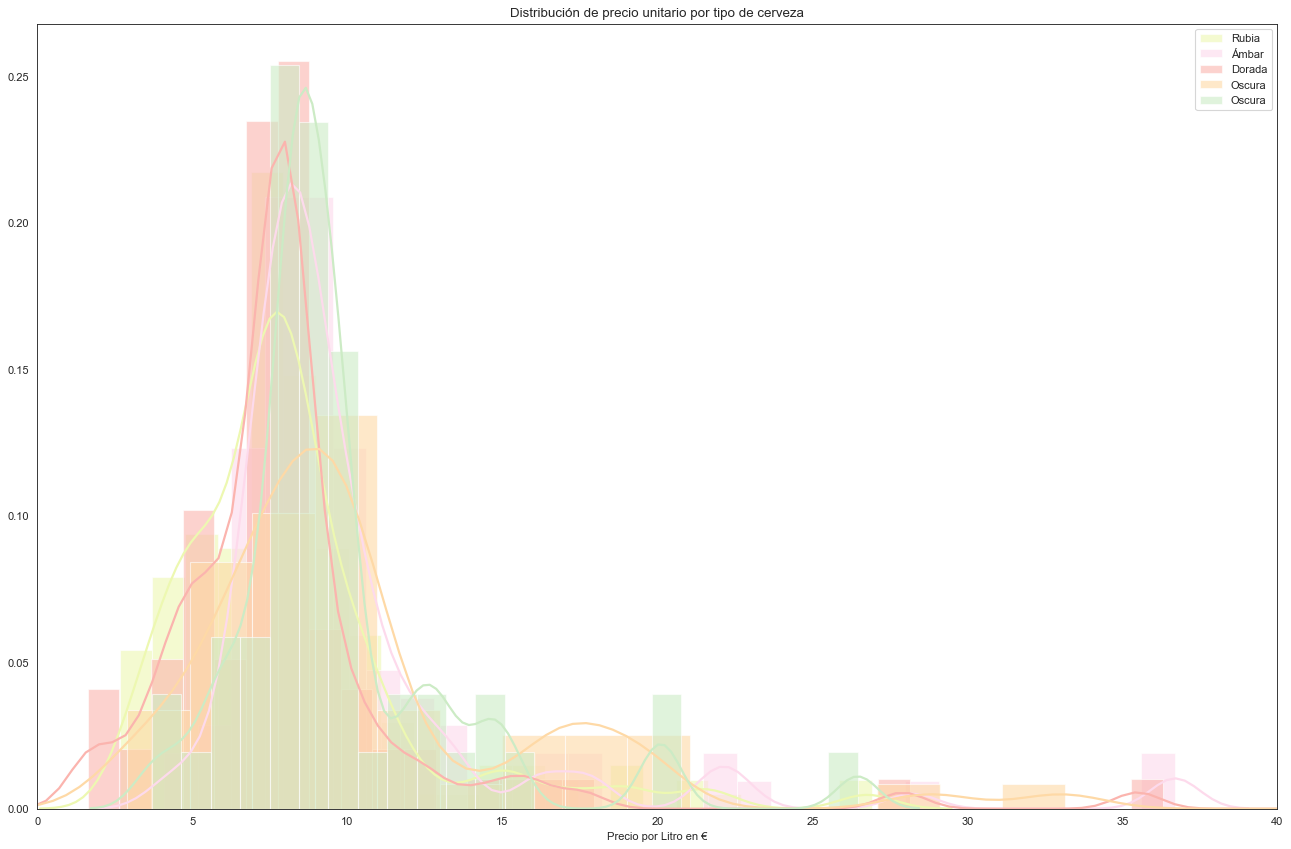

In [123]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("white")

x1 = data_beers_web_sacraping.loc[data_beers_web_sacraping['Color Simplificado']=='Rubia','Precio por Litro en €']
x2 = data_beers_web_sacraping.loc[data_beers_web_sacraping['Color Simplificado']=='Ámbar','Precio por Litro en €']
x3 = data_beers_web_sacraping.loc[data_beers_web_sacraping['Color Simplificado']=='Dorada','Precio por Litro en €']
x4 = data_beers_web_sacraping.loc[data_beers_web_sacraping['Color Simplificado']=='Oscura','Precio por Litro en €']
x5 = data_beers_web_sacraping.loc[data_beers_web_sacraping['Color Simplificado']=='Marrón','Precio por Litro en €']


# Plot
kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})

plt.figure(figsize=(20,13), dpi= 80)
sns.distplot(x1, color="#edf8b1", label="Rubia", **kwargs)
sns.distplot(x2, color="#fddaec", label="Ámbar", **kwargs)
sns.distplot(x3, color="#fbb4ae", label="Dorada", **kwargs)
sns.distplot(x4, color="#fed9a6", label="Oscura", **kwargs)
sns.distplot(x5, color="#ccebc5", label="Oscura", **kwargs)

plt.xlim(0,40)
plt.legend()
plt.title('Distribución de precio unitario por tipo de cerveza');


In [80]:
data_beers_web_sacraping.to_csv(r'C:\Users\guillermo.arguello\Documents\Master Data Science UOC\Tipología y ciclo de vida de los datos\Pec1 2020\data_beers_web_sacraping.csv',
          encoding = 'ANSI',index=False)